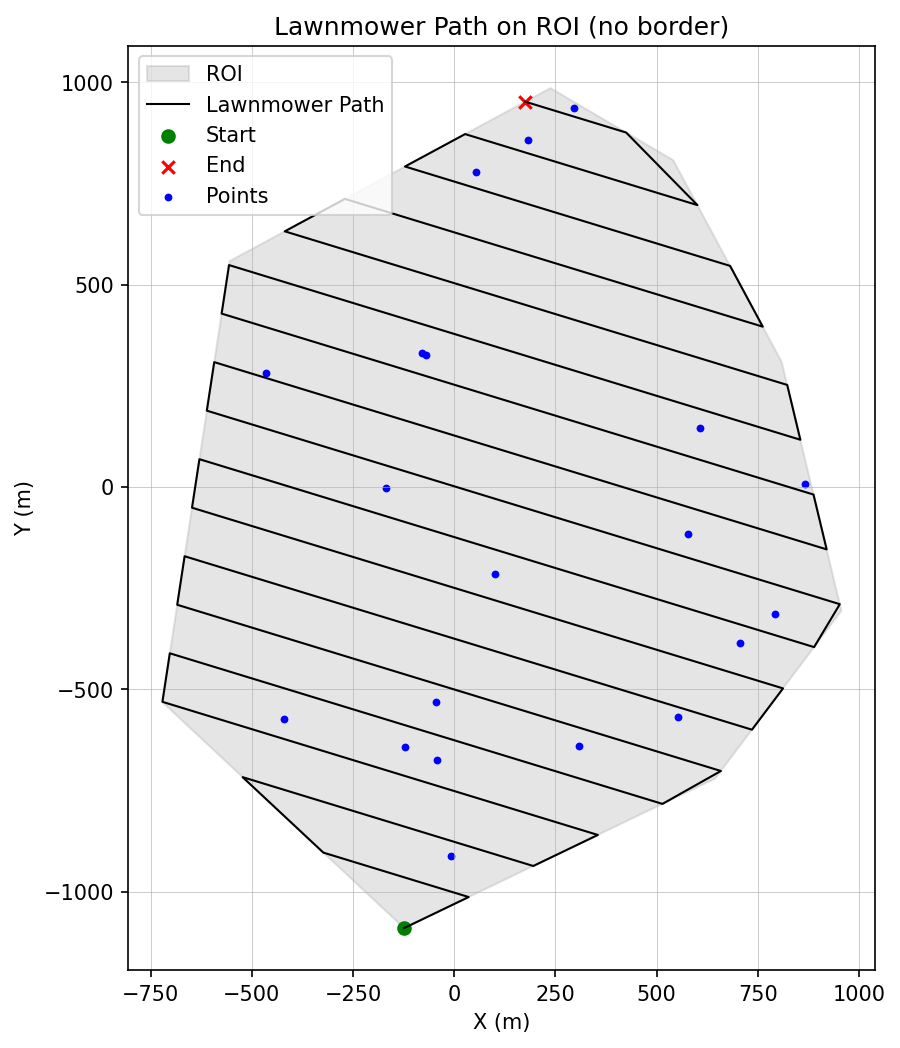

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPoint, Point

# ----------------- 랜덤 영역 생성 -----------------
def random_convex_polygon(n_points=12, radius=1000, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    angles = np.sort(np.random.rand(n_points) * 2 * np.pi)
    radii = radius * (0.6 + 0.4 * np.random.rand(n_points))
    xs = radii * np.cos(angles)
    ys = radii * np.sin(angles)
    hull = MultiPoint(list(zip(xs, ys))).convex_hull
    return hull if isinstance(hull, Polygon) else None

# ----------------- 라운드모어 경로 -----------------
def lawnmower(poly_xy: Polygon, spacing=80.0, angle_deg=0.0):
    angle = np.deg2rad(angle_deg)
    cos_a, sin_a = np.cos(angle), np.sin(angle)

    def rot(p): return (p[0]*cos_a - p[1]*sin_a, p[0]*sin_a + p[1]*cos_a)
    def invrot(p): return (p[0]*cos_a + p[1]*sin_a, -p[0]*sin_a + p[1]*cos_a)

    poly_rot = Polygon([rot((x, y)) for x, y in poly_xy.exterior.coords])

    minx, miny, maxx, maxy = poly_rot.bounds
    y = miny
    flip = False
    path = []
    while y <= maxy:
        seg = LineString([(minx, y), (maxx, y)]).intersection(poly_rot)
        if not seg.is_empty:
            if seg.geom_type == "MultiLineString":
                seg = max(seg.geoms, key=lambda s: s.length)
            coords = list(seg.coords)
            if flip: coords.reverse()
            coords = [invrot(p) for p in coords]
            path.extend(coords)
        y += spacing
        flip = not flip
    return path

# ----------------- 다각형 내부 점 생성 -----------------
def random_points_in_polygon(poly: Polygon, n_points=20, seed=None):
    if seed is not None:
        random.seed(seed)
    minx, miny, maxx, maxy = poly.bounds
    points = []
    while len(points) < n_points:
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        if poly.contains(Point(x, y)):
            points.append((x, y))
    return points

# ----------------- 실행 -----------------
if __name__ == "__main__":
    poly = random_convex_polygon(n_points=15, radius=1200, seed=42)
    path_xy = lawnmower(poly, spacing=120.0, angle_deg=17.0)
    rand_pts = random_points_in_polygon(poly, n_points=20, seed=99)

    fig, ax = plt.subplots(figsize=(8,8), dpi=150)
    px, py = poly.exterior.xy

    # ROI: 테두리 없이 채우기
    ax.fill(px, py, alpha=0.2, color="gray", label="ROI")

    # 라운드모어 경로
    if path_xy:
        xs, ys = zip(*path_xy)
        ax.plot(xs, ys, linewidth=1, label="Lawnmower Path", color="black")
        ax.scatter([xs[0]], [ys[0]], c="green", marker="o", label="Start")
        ax.scatter([xs[-1]], [ys[-1]], c="red", marker="x", label="End")

    # 랜덤 점
    if rand_pts:
        rx, ry = zip(*rand_pts)
        ax.scatter(rx, ry, c="blue", s=30, marker=".", label="Points")

    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Lawnmower Path on ROI (no border)")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.grid(True, linewidth=0.3)
    ax.legend()
    plt.show()